# Analysis of experimental data with QPU

## Classic FT analysis

In [63]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

MEGA = 1e6
GIGA = 1e9
MICRO = 1e-6
NANO = 1e-9


def read_signal_txt(xfile, yfile, timescale=1e-9):
    with open(xfile, 'r') as f:
        x = np.array([float(d) * timescale for d in f.readlines()])
    with open(yfile, 'r') as f:
        y = np.array([float(d) for d in f.readlines()])
    return x, y


def read_signal_dat(file, timescale=1e-9):
    with open(file, 'r') as f:
        x = np.array([[float(x[0]) * timescale, float(x[1])] for x in [d.split() for d in f.readlines()]])
    return x[:,0], x[:, 1]

keys = ["Jeshcke_Birad_80K_Qband", "TbypT_Birad_RT_Xband", "Test_Birad_80K_Qband"]
NS = [16, 32, 64]

In [28]:
graphs = {}
for key in keys:
    x, y = read_signal_dat(f'oscillations/new_data/{key}.dat')
    graphs[key] = {"00 raw": (x, y)}

In [161]:
def show_subplots(data, vertical=True, x_ranges=None, sharex=False, sharey=False):
    import matplotlib
    
    rolling = [
        ('gray', ':', '', 1),
        ('#222222', '-', 'o', 2),
        ('green', '--', '*', 2),
        ('blue', ':', '+', 1),
        ('blue', '-', '*', 1),
        ('black', '-', '^', 2)
    ]
    
    matplotlib.rcParams.update({'font.size': 16})
    n = len(data)
    fig, ax = plt.subplots(n if vertical else 1, 1 if vertical else n, 
                               sharex=sharex, sharey=sharey, figsize=(20, 20))
    for i, key in enumerate(data.keys()):
        charts = data[key]
        for j, g in enumerate(sorted(list(charts.keys()))):
            ax[i].plot(
                charts[g][0], charts[g][1], label=g,
                color = rolling[j % len(rolling)][0],
                ls    = rolling[j % len(rolling)][1],
                marker= rolling[j % len(rolling)][2],
                lw    = rolling[j % len(rolling)][3],
            )
            if x_ranges is not None and key in x_ranges:
                ax[i].set_xlim(x_ranges[key])
                    
        ax[i].legend()
        ax[i].set_title(key)
    # plt.subplots_adjust(top=2)
    plt.tight_layout()
    plt.show()

### Input data, subsampled

In [ ]:
show_subplots(graphs)

In [115]:
def subsample(x, y, shift, step, N):
    i = 0
    while x[i] < shift: i += 1
    result = x[i:i + (step * N):step], y[i:i + (step * N):step]
    return result

shifts = {
    "Jeshcke_Birad_80K_Qband" : 396 * NANO, 
    "TbypT_Birad_RT_Xband": 44 * NANO, 
    "Test_Birad_80K_Qband": 72 * NANO,
}
steps16 = {
    "Jeshcke_Birad_80K_Qband" : 16, 
    "TbypT_Birad_RT_Xband": 4, 
    "Test_Birad_80K_Qband": 8,
}
steps32 = {
    "Jeshcke_Birad_80K_Qband" : 8, 
    "TbypT_Birad_RT_Xband": 2, 
    "Test_Birad_80K_Qband": 4,
}
steps64 = {
    "Jeshcke_Birad_80K_Qband" : 4, 
    "TbypT_Birad_RT_Xband": 1, 
    "Test_Birad_80K_Qband": 2,
}

steps = {
    16: steps16, 32: steps32, 64: steps64
}

x_ranges = {}

for N in steps:
    for key in keys:
        x, y = read_signal_dat(f'oscillations/new_data/{key}.dat')
        x, y = subsample(x, y, shift=shifts[key], step=steps[N][key], N=N)
        graphs[key][f"{N}"] = (x, y)
        if N == 64:
            x_ranges[key] = min(x), max(x)

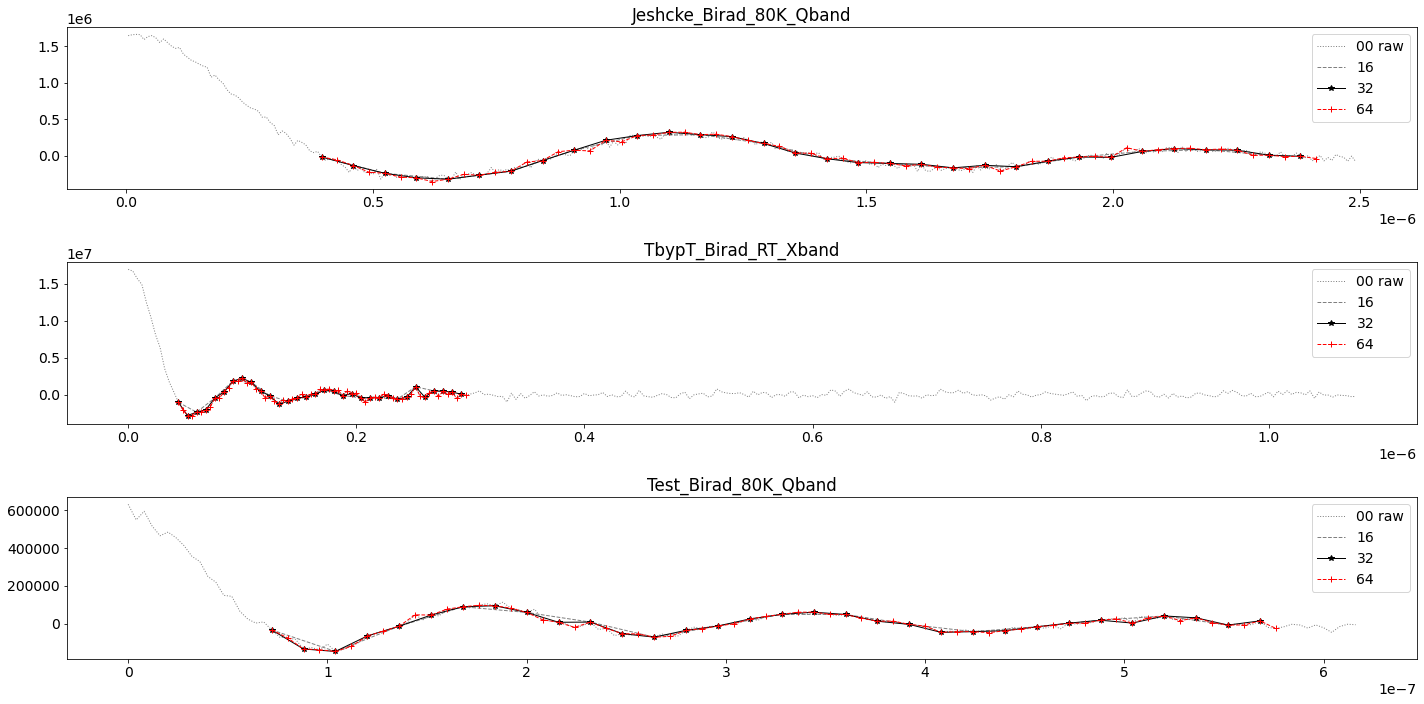

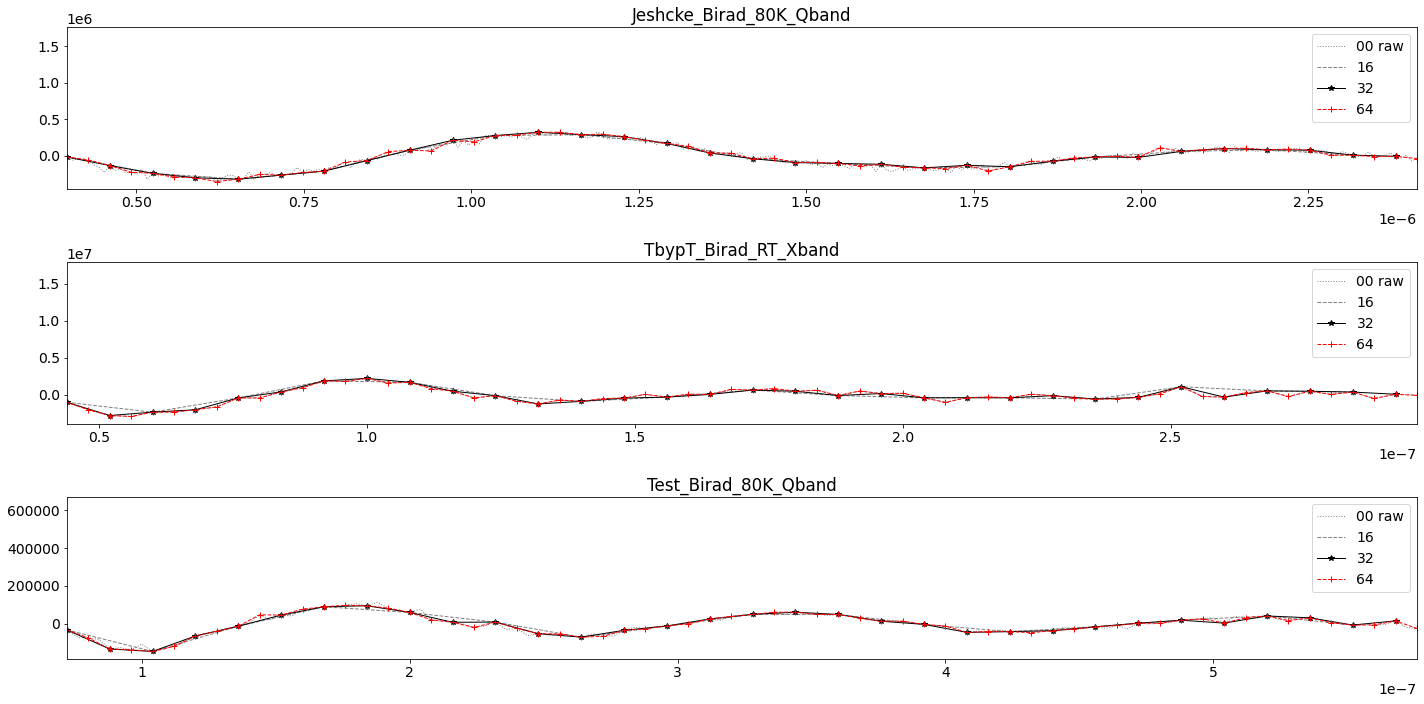

In [116]:
show_subplots(graphs)
show_subplots(graphs, x_ranges=x_ranges)

In [117]:
def fft(x, y):
    fy = np.fft.fft(y)
    fx = np.fft.fftfreq(len(y), x[1] - x[0])
    data = np.array(sorted(list(zip(fx, fy))))
    return data[:, 0].real, abs(data[:, 1])

def norm(x, y):
    return x, (y / max(y))

In [118]:
fft_graphs = {}
freq_ranges = {}

for key in keys:
    fft_graphs[key] = {}
    for graph in graphs[key]:
        x, y = graphs[key][graph]
        fx, fy = norm(*fft(x, y))
        fft_graphs[key][f'FFT {graph}'] = (fx, fy)
        if graph == '64':
            freq_ranges[key] = min(fx), max(fx)

### Fourier analysis

We can observe, that sampling changes the distribution, but keeps the peaks.

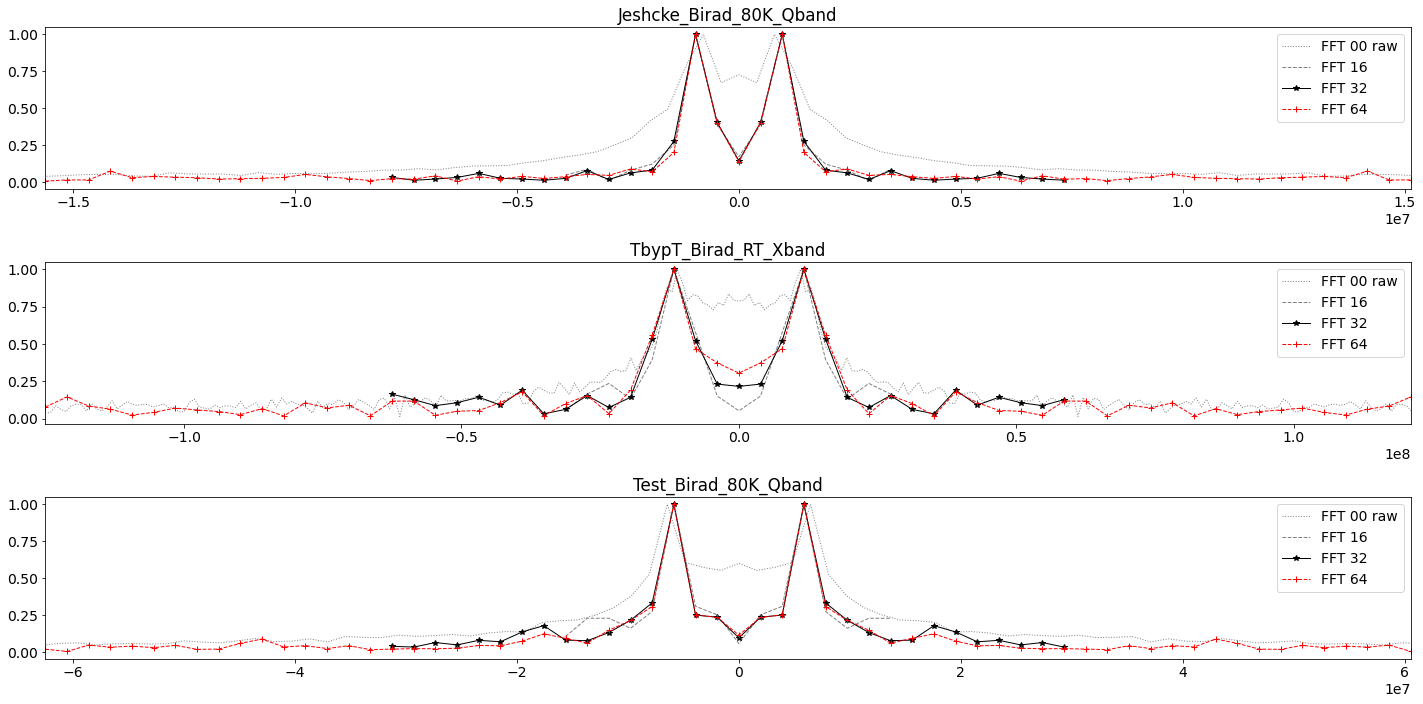

In [119]:
show_subplots(fft_graphs, x_ranges=freq_ranges)

## Quantum part

In [84]:
from qiskit import QuantumCircuit, BasicAer, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library import QFT
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit_ionq import IonQProvider

AZURE = None

def _get_azure_provider():
    global AZURE
    if AZURE is None:
        AZURE = AzureQuantumProvider(resource_id = open('azure.key').read(), location = "eastus")
    return AZURE


def _get_ionq_backend(realqpu):
    provider = _get_azure_provider()
    simulator_backend = provider.get_backend("ionq.qpu" if realqpu else "ionq.simulator")
    return simulator_backend


def run_circuit(circuit, qpu, shots=1000):
    print(f"Running {shots} shots on {qpu.name()}")
    start = time.time()
    if qpu.name() != 'qasm_simulator':
        job = qpu.run(circuit, shots=shots)
        job_id = job.id()
        print("Job id", job_id)
        job_monitor(job)
        print(f"{time.time() - start:3f} seconds spent")
    else:
        job = execute(circuit, shots=shots, backend=qpu)
        print('local simulation')
        print(f"{time.time() - start:3f} seconds spent")
    return job.result()


In [145]:
SIMULATOR = _get_ionq_backend(False)
QPU = _get_ionq_backend(True)
QASM = BasicAer.get_backend('qasm_simulator')

In [72]:
def get_circuit(data):
    import math
    dim = math.ceil(math.log2(len(data)))
    print("Required qubits:", dim)
    data_padded = np.zeros((2 ** dim,))
    data_padded[:len(data)] = data
    data_normed = data_padded / np.linalg.norm(abs(data_padded))
    qr = QuantumRegister(dim, name="qubits")
    cr = ClassicalRegister(dim, name="classical")
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(data_normed)
    #circuit.barrier()
    circuit.append(QFT(dim), qr)
    #circuit.barrier()
    circuit.measure(qr, cr)
    return circuit

### Building circuits

In [75]:
circuits = {}
for key in keys:
    circuits[key] = {}
    for N in NS:
        x, y = read_signal_dat(f'oscillations/new_data/{key}.dat')
        x, y = subsample(x, y, shift=shifts[key], step=steps[N][key], N=N)
        circuits[key][N] = transpile(get_circuit(y), backend=SIMULATOR)
        print(f"\t\t{key} {N} depth: {circuits[key][N].depth()}")

Required qubits: 4
		Jeshcke_Birad_80K_Qband 16 depth: 55
Required qubits: 5
		Jeshcke_Birad_80K_Qband 32 depth: 117
Required qubits: 6
		Jeshcke_Birad_80K_Qband 64 depth: 243
Required qubits: 4
		TbypT_Birad_RT_Xband 16 depth: 50
Required qubits: 5
		TbypT_Birad_RT_Xband 32 depth: 107
Required qubits: 6
		TbypT_Birad_RT_Xband 64 depth: 243
Required qubits: 4
		Test_Birad_80K_Qband 16 depth: 55
Required qubits: 5
		Test_Birad_80K_Qband 32 depth: 117
Required qubits: 6
		Test_Birad_80K_Qband 64 depth: 226


### Circuit simplification

In [78]:
def clean(data, threshold):
    newdata = []
    for i, gate in enumerate(data):
        if gate[0].name == 'reset':
            print('-init;', end=' ')
            continue
            
        if gate[0].name == 'ry':
            if abs(gate[0]._params[0]) <= threshold:
                print(f'-ry{gate[0]._params[0]:.3f};', end=' ')
                continue
                
        if gate[0].name == 'rz':
            if abs(gate[0]._params[0]) <= threshold:
                print('-rz;', end=' ')
                continue
                
        if gate[0].name == 'u':
            a, b, c = gate[0]._params
            if a == b == 0 and abs(c) <= threshold:
                print('-u;', end=' ')
                continue

        if gate[0].name == 'u':
            a, b, c = gate[0]._params
            if abs(a) <= threshold and abs(b) <= threshold and abs(c) <= threshold:
                print('-u;', end=' ')
                continue 
        newdata.append(gate)
    print()
    
    #todo remove CX
    i = len(newdata) - 1
    while i >= 0 and newdata[i][0].name != 'swap':
        i -= 1
    e = i
    while i >= 0 and newdata[i][0].name == 'swap':
        i -= 1
    if i > 0:
        return newdata[:i+1] + newdata[e+1:]
    else:
        return newdata
    
def collapse(data):
    newdata = []
    olddata = list(data)
    for i, _ in enumerate(data):
        gate = olddata[i]
        
        if gate is None:
            print("-cx;", end=" ")
            continue
        
        if gate[0].name == 'cx':
            gate_1 = olddata[i+1]
            gate_2 = olddata[i+2]

            if gate_1 is not None and gate_2 is not None and gate_2[0].name == 'cx' and gate_1[0].name == 'cx':
                if gate_2[1] == gate[1]:
                    print('Matching CX pair... ', end="")
                    olddata[i+2] = None
                    continue
        newdata.append(gate)
    return newdata


def do_clean(circuit):
    circuit.data = clean(circuit.data,  50 * np.pi * 1e-3)
    print(circuit.depth())
    for i in range(6):
        circuit.data = collapse(circuit.data)
        print("Depth:", circuit.depth())    

In [79]:
for key in keys:
    for N in NS:
        do_clean(circuits[key][N])

-ry-0.013; -ry-0.080; -ry-0.145; -ry-0.069; -ry0.007; -ry0.139; 
48
Depth: 48
Depth: 48
Depth: 48
Depth: 48
Depth: 48
Depth: 48
-ry-0.036; -ry-0.071; -ry0.113; -ry-0.001; -ry-0.039; -ry0.028; -ry-0.009; -ry0.068; -ry0.079; -ry0.075; -ry0.012; -ry0.062; -ry-0.058; -ry-0.003; -ry-0.009; -ry0.131; -ry0.013; -ry-0.009; 
98
Matching CX pair... -cx; Matching CX pair... -cx; Matching CX pair... -cx; Depth: 92
Matching CX pair... -cx; Depth: 90
Matching CX pair... -cx; Depth: 88
Depth: 88
Depth: 88
Depth: 88
-ry-0.137; -ry-0.053; -rz; -rz; -rz; -rz; -ry-0.033; -ry0.098; -ry-0.059; -ry0.039; -ry0.031; -ry0.058; -rz; -rz; -rz; -rz; -ry0.148; -ry0.027; -ry-0.120; -ry0.111; -ry-0.069; -ry0.145; -ry-0.114; -ry-0.025; -ry0.118; -ry-0.135; -ry0.139; -ry-0.136; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -rz; -ry-0.054; -ry0.030; -ry0.008; -ry0.001; -ry-0.153; -ry-0.028; -ry0.105; -ry0.108; -ry-0.138; -ry-0.011; -ry0.018; -ry-0.007; -ry0.091; -ry-0.035; -ry0.056; -ry-0.062; -ry-0.154; -ry-0

In [132]:
## !!!! ALREADY SQUARE ROOT
def to_values(x, counts_raw, N=5, reorder=True):
    f = "{0:0" + str(N) + "b}"
    for i in range(2 ** N):
        if f.format(i) not in counts_raw:
            counts_raw[f.format(i)] = 0
    ints = [[int(k[::-1] if reorder else k, base=2), v ** .5] for (k, v) in counts_raw.items()]
    ints = sorted(ints)
    # negative frequencies
    ints = ints[len(ints) // 2:] + ints[:len(ints) // 2]
    y = np.array(ints)[:, 1]
    return norm(x, y)

### Running QFT simulations

In [134]:
import math 
qft1 = {}

for key in keys:
    qft1[key] = {}
    qft1[key]['FFT'] = fft_graphs[key][f'FFT 00 raw']
    for N in NS:
        result = run_circuit(circuits[key][N], qpu=QASM, shots=5000).get_counts()
        print(key, N)
        print(result)
        x, y = fft_graphs[key][f'FFT {N}']
        fx, vals = to_values(x, result, N=int(math.log2(N))) 
        qft1[key][f"QFT' QASM {N}"] = fx, vals

Running 5000 shots on qasm_simulator
local simulation
0.088608 seconds spent
Jeshcke_Birad_80K_Qband 16
{'0111': 2023, '0100': 1940, '1111': 277, '1010': 33, '1000': 280, '1100': 140, '1011': 147, '0000': 37, '1101': 37, '1001': 3, '0011': 45, '0010': 23, '0110': 7, '0001': 5, '0101': 3}
Running 5000 shots on qasm_simulator
local simulation
0.143081 seconds spent
Jeshcke_Birad_80K_Qband 32
{'01000': 2035, '01111': 1926, '10111': 123, '11000': 145, '11111': 321, '10000': 304, '11110': 1, '00101': 4, '11100': 6, '00000': 38, '11011': 6, '10101': 6, '10100': 11, '11010': 6, '01100': 1, '00010': 3, '00011': 3, '10010': 7, '10011': 7, '00100': 9, '00111': 15, '11101': 6, '10110': 3, '01011': 2, '11001': 5, '00110': 6, '01101': 1}
Running 5000 shots on qasm_simulator
local simulation
0.134589 seconds spent
Jeshcke_Birad_80K_Qband 64
{'111111': 331, '011111': 1918, '010000': 1930, '101111': 78, '100000': 273, '101000': 4, '110000': 114, '001110': 9, '001100': 12, '111100': 6, '100001': 4, '11

============ FFT ================


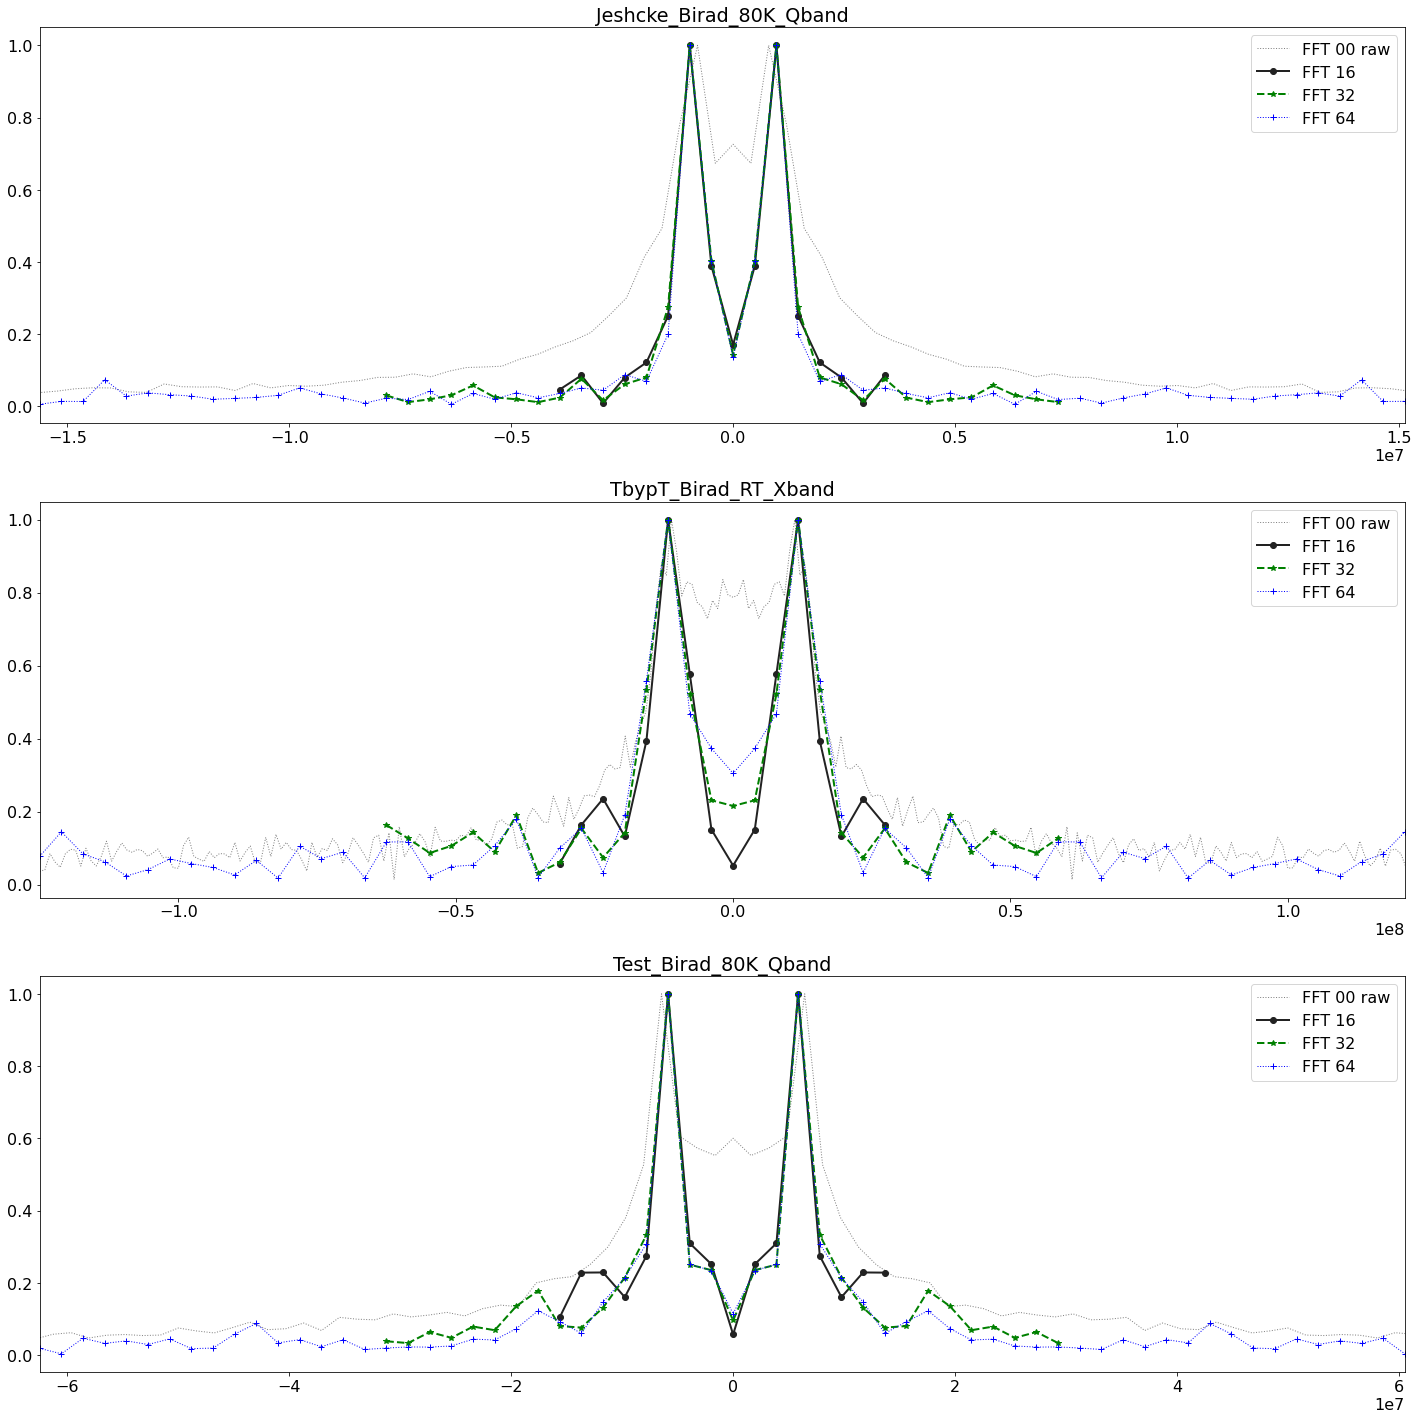

===== QFT SIMULATION ============


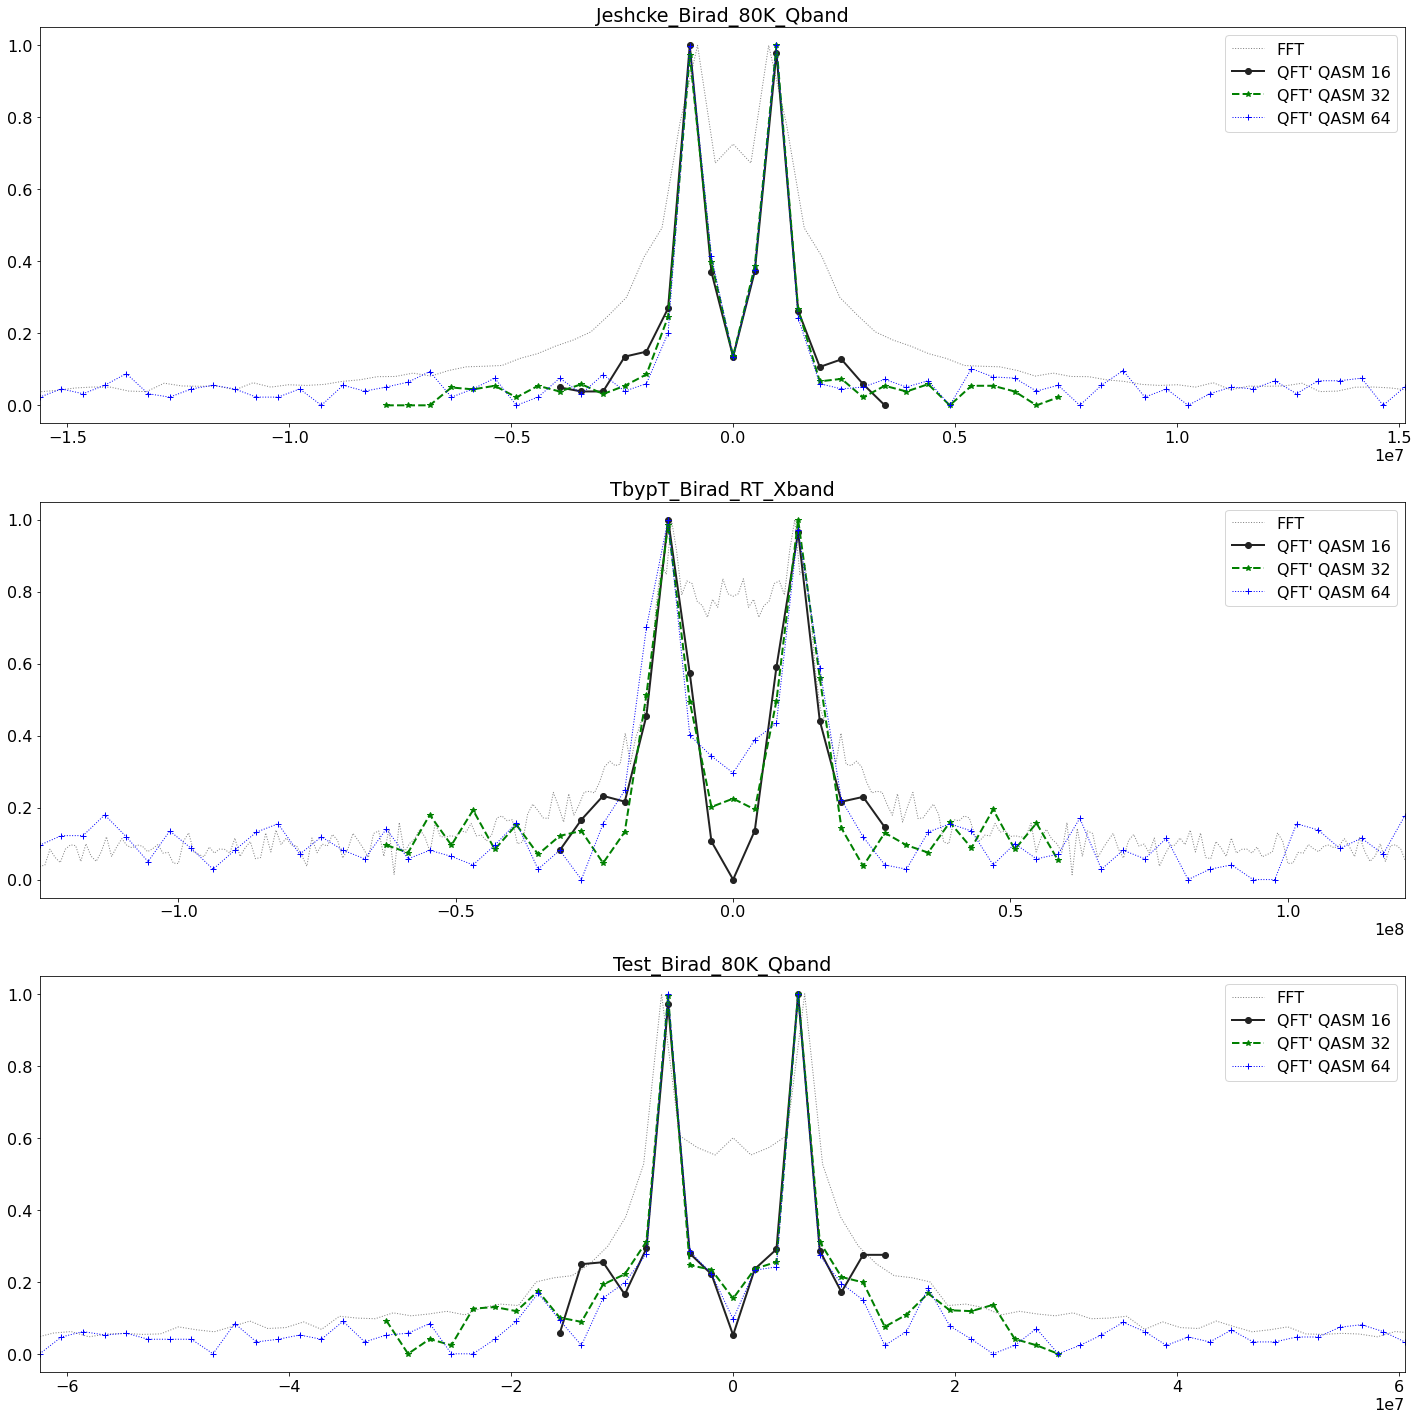

In [164]:
print("============ FFT ================")
show_subplots(fft_graphs, x_ranges=freq_ranges)
print("===== QFT SIMULATION ============")
show_subplots(qft1, x_ranges=freq_ranges)

### Data compression to reduce circuit complexity

In [136]:
def pairwise_average(data):
    v = (data[0::2] + data[1::2]) / 2
    r = np.zeros(data.shape)
    r[::2] = v
    r[1::2] = v
    return r

In [137]:
circuits2 = {}

for key in keys:
    circuits2[key] = {}
    for N in NS:
        x, y = read_signal_dat(f'oscillations/new_data/{key}.dat')
        x, y = subsample(x, y, shift=shifts[key], step=steps[N][key], N=N)
        y = pairwise_average(y)
        circuits2[key][N] = transpile(get_circuit(y), backend=SIMULATOR)
        print(f"\t\t{key} {N} depth: {circuits2[key][N].depth()}")
        
for key in keys:
    for N in NS:
        do_clean(circuits2[key][N])

Required qubits: 4
		Jeshcke_Birad_80K_Qband 16 depth: 29
Required qubits: 5
		Jeshcke_Birad_80K_Qband 32 depth: 76
Required qubits: 6
		Jeshcke_Birad_80K_Qband 64 depth: 155
Required qubits: 4
		TbypT_Birad_RT_Xband 16 depth: 37
Required qubits: 5
		TbypT_Birad_RT_Xband 32 depth: 76
Required qubits: 6
		TbypT_Birad_RT_Xband 64 depth: 155
Required qubits: 4
		Test_Birad_80K_Qband 16 depth: 37
Required qubits: 5
		Test_Birad_80K_Qband 32 depth: 76
Required qubits: 6
		Test_Birad_80K_Qband 64 depth: 155
-ry0.111; -ry0.096; -ry-0.114; 
25
Matching CX pair... -cx; Matching CX pair... -cx; Matching CX pair... -cx; Depth: 17
Matching CX pair... -cx; Depth: 16
Depth: 16
Depth: 16
Depth: 16
Depth: 16
-ry-0.030; -ry-0.077; -ry0.146; -ry-0.017; -ry-0.020; -ry0.048; 
69
Matching CX pair... -cx; Matching CX pair... -cx; Matching CX pair... -cx; Matching CX pair... -cx; Matching CX pair... -cx; Depth: 58
Matching CX pair... -cx; Matching CX pair... -cx; Depth: 52
Matching CX pair... -cx; Depth: 48


In [142]:
import math 
qft1_5 = {}

for key in keys:
    qft1_5[key] = {}
    qft1_5[key]['FFT'] = fft_graphs[key][f'FFT 00 raw']
    for N in NS:
        result = run_circuit(circuits2[key][N], qpu=QASM, shots=5000).get_counts()
        print(key, N)
        print(result)
        x, y = fft_graphs[key][f'FFT {N}']
        fx, vals = to_values(x, result, N=int(math.log2(N))) 
        qft1_5[key][f"QFT'' QASM {N}"] = fx, vals

Running 5000 shots on qasm_simulator
local simulation
0.084301 seconds spent
Jeshcke_Birad_80K_Qband 16
{'0100': 1752, '0111': 1691, '0101': 275, '1000': 345, '0110': 290, '1111': 340, '0000': 101, '1011': 65, '1001': 14, '1101': 33, '1100': 45, '1010': 25, '1110': 12, '0011': 4, '0010': 8}
Running 5000 shots on qasm_simulator
local simulation
0.084697 seconds spent
Jeshcke_Birad_80K_Qband 32
{'01111': 1941, '01000': 1905, '11111': 325, '01110': 77, '11000': 115, '10000': 307, '01001': 79, '00000': 36, '01100': 8, '10111': 120, '11001': 16, '00111': 8, '00010': 5, '11100': 1, '00110': 2, '11011': 8, '11101': 2, '10110': 9, '11010': 4, '01101': 1, '10001': 2, '10100': 10, '00100': 8, '10101': 3, '00101': 1, '01011': 2, '00011': 1, '11110': 3, '01010': 1}
Running 5000 shots on qasm_simulator
local simulation
0.178316 seconds spent
Jeshcke_Birad_80K_Qband 64
{'010000': 2002, '011111': 1847, '100111': 1, '010001': 26, '100000': 358, '101000': 15, '111111': 379, '011101': 5, '011110': 25, '

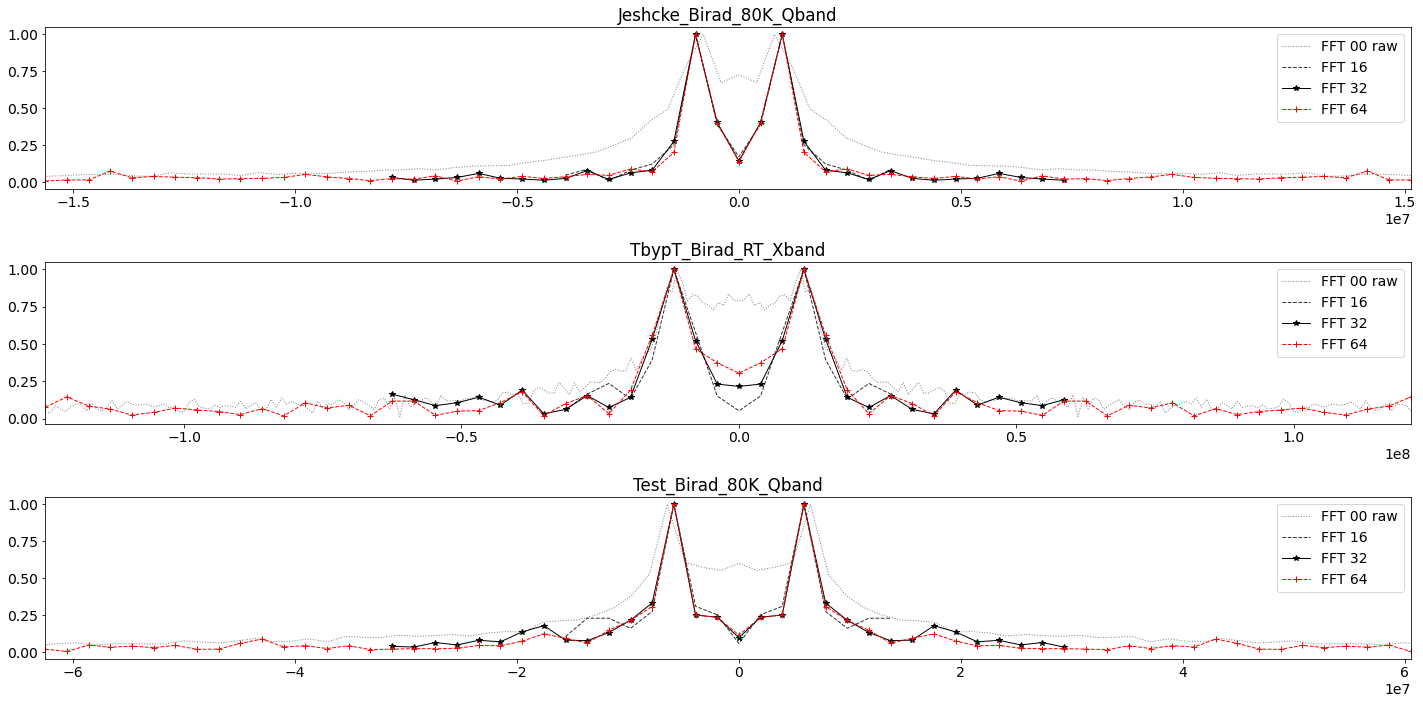

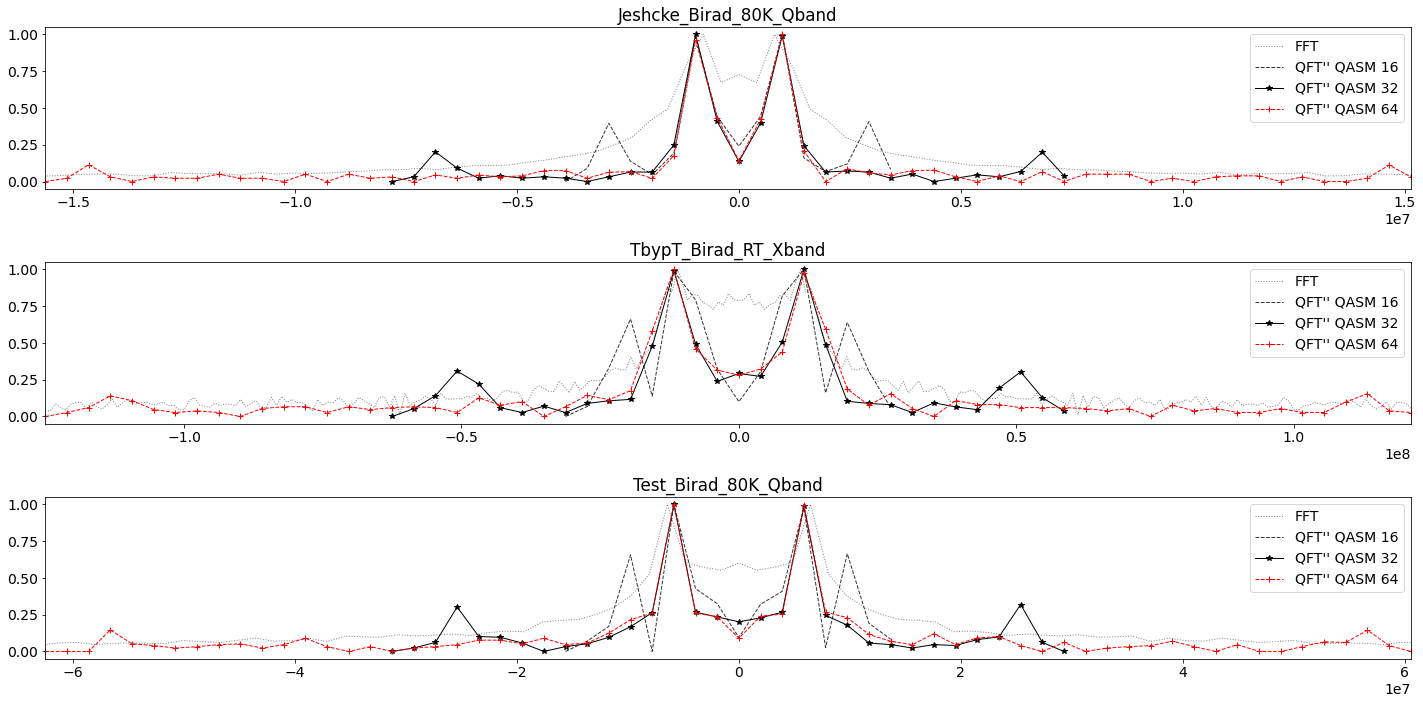

In [143]:
show_subplots(fft_graphs, x_ranges=freq_ranges)
show_subplots(qft1_5, x_ranges=freq_ranges)

### Real QPU experiments

In [146]:
import math 
qft2 = {}

for key in keys:
    qft2[key] = {}
    qft2[key]['FFT'] = fft_graphs[key][f'FFT 00 raw']
    for N in NS:
        result = run_circuit(circuits2[key][N], qpu=QPU, shots=1000).get_counts()
        print(key, N)
        print(result)
        x, y = fft_graphs[key][f'FFT {N}']
        fx, vals = to_values(x, result, N=int(math.log2(N))) 
        qft2[key][f"QFT QPU {N}"] = fx, vals

Running 1000 shots on ionq.qpu
Job id 937113a7-a079-11ec-839c-d4258b36ead3
Job Status: job has successfully run
111.204593 seconds spent
Jeshcke_Birad_80K_Qband 16
{'0000': 23, '0001': 5, '0010': 4, '0011': 5, '0100': 354, '0101': 96, '0110': 51, '0111': 260, '1000': 43, '1001': 11, '1010': 5, '1011': 17, '1100': 30, '1101': 20, '1110': 23, '1111': 53}
Running 1000 shots on ionq.qpu
Job id d6624396-a079-11ec-9bbe-d4258b36ead3
Job Status: job has successfully run
104.624094 seconds spent
Jeshcke_Birad_80K_Qband 32
{'00000': 31, '00001': 53, '00010': 23, '00011': 30, '00100': 22, '00101': 22, '00110': 17, '00111': 42, '01000': 49, '01001': 43, '01010': 18, '01011': 39, '01100': 34, '01101': 35, '01110': 14, '01111': 67, '10000': 37, '10001': 37, '10010': 16, '10011': 22, '10100': 25, '10101': 35, '10110': 17, '10111': 18, '11000': 21, '11001': 35, '11010': 16, '11011': 21, '11100': 48, '11101': 49, '11110': 28, '11111': 36}
Running 1000 shots on ionq.qpu
Job id 155bc921-a07a-11ec-b29e-d4

=============== Simulated ==========================


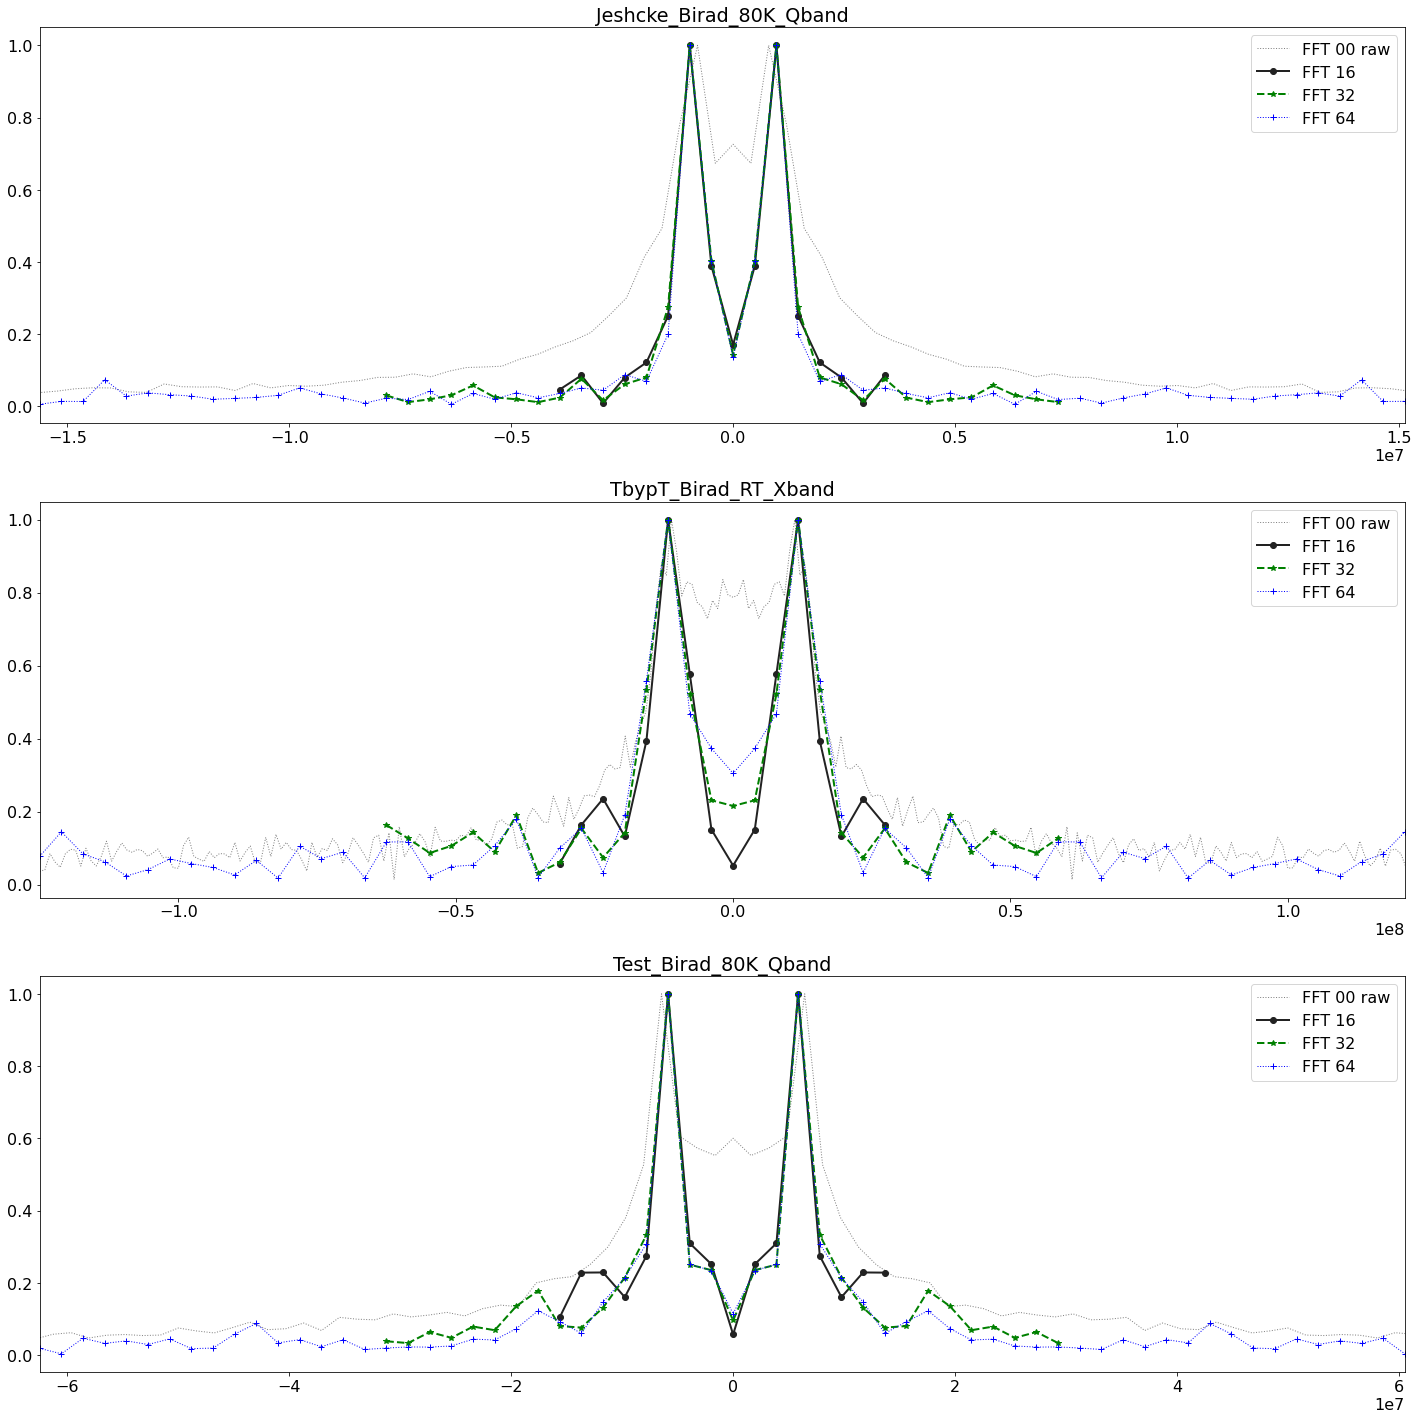

================= QPU ==============================


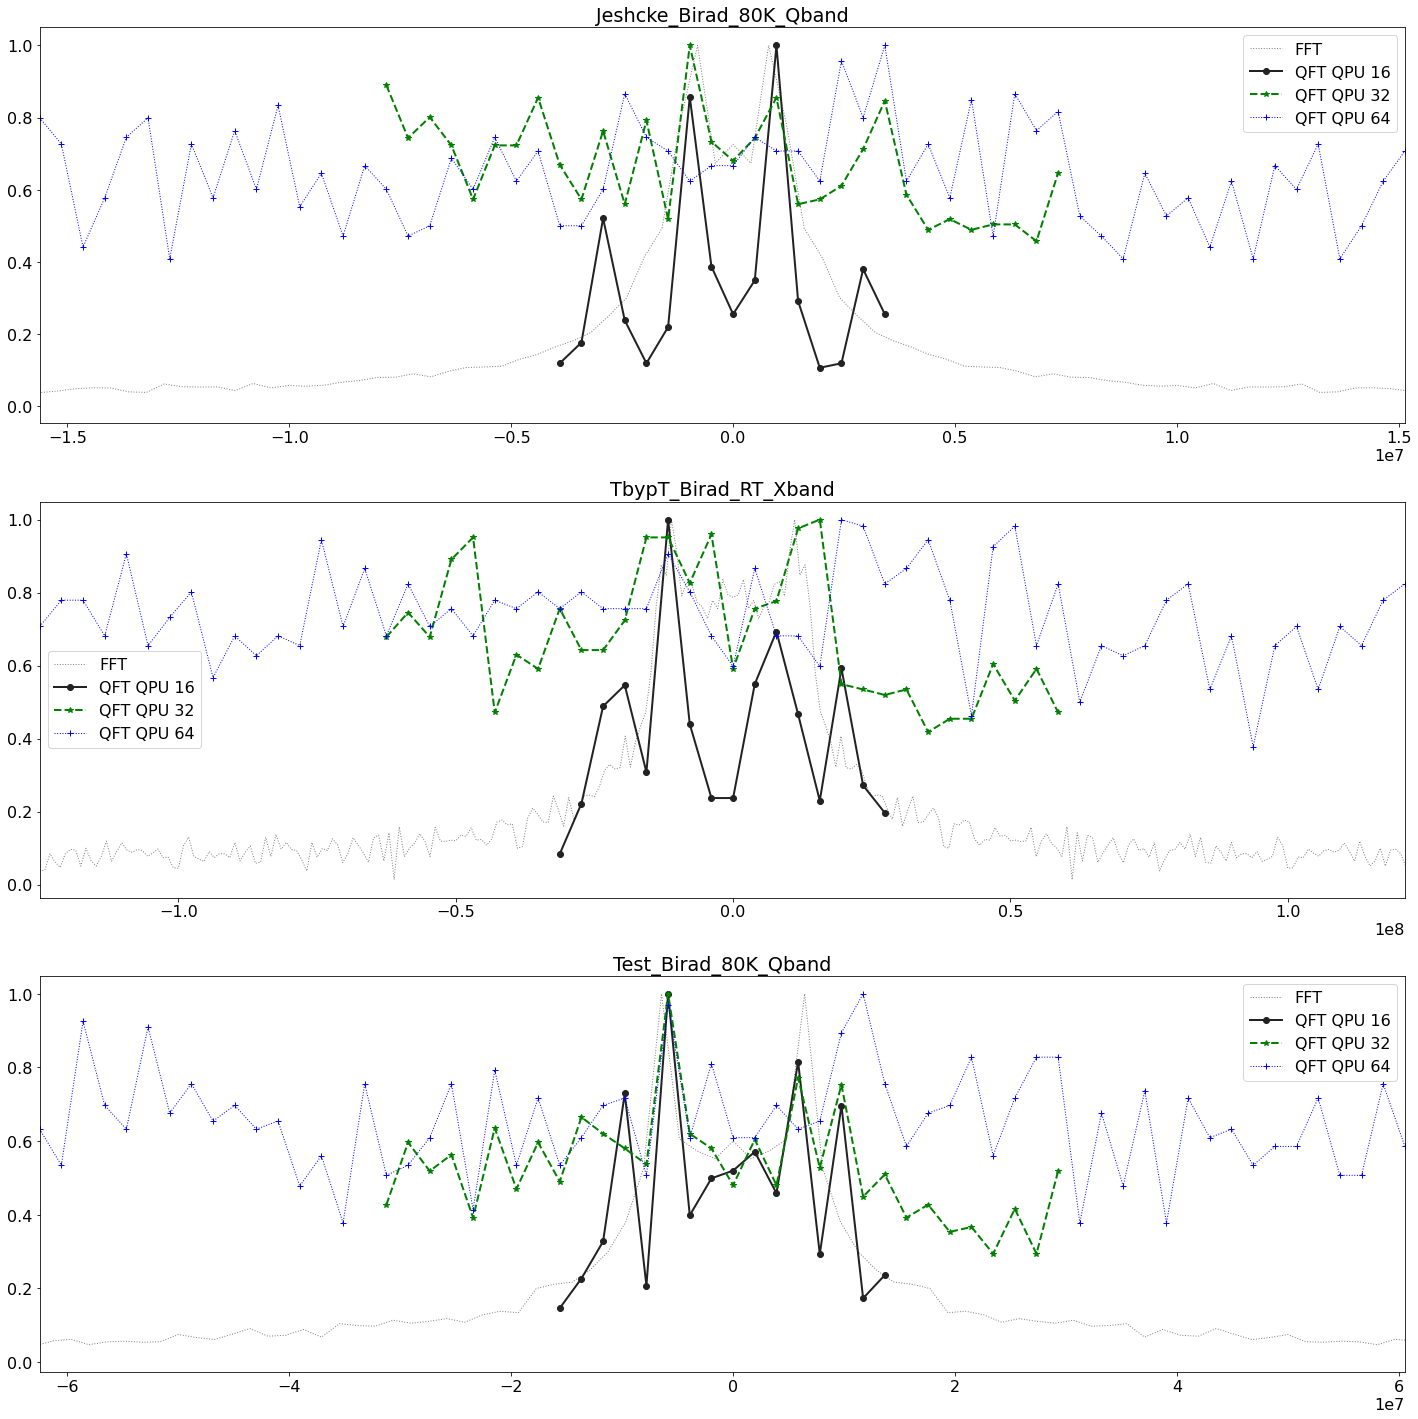

In [162]:
print("=============== Simulated ==========================")
show_subplots(fft_graphs, x_ranges=freq_ranges)
print("================= QPU ==============================")
show_subplots(qft2, x_ranges=freq_ranges)